In [1]:
import random

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
root = '/home/wilsonyan/data/mnist'

In [3]:
batch_size = 32

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dset_train = datasets.MNIST(root, train=True, download=True, transform=transform)
dset_test = datasets.MNIST(root, train=False, download=True, transform=transform)

loader_train = data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)
loader_test = data.DataLoader(dset_test, batch_size=batch_size, shuffle=True)

In [5]:
def squash(x, dim=-1):
    norm_squared = torch.sum(x ** 2, dim, keepdim=True)
    x = norm_squared / (1 + norm_squared) * x / torch.sqrt(norm_squared)
    return x

In [6]:
def margin_loss(out, y):
    pred = torch.sqrt((out ** 2).sum(-1))
    loss = y * torch.max(0.9 - pred, 0)[0] ** 2 + 0.5 * (1 - y) * torch.max(pred - 0.1, 0)[0] ** 2
    return loss.sum(1).mean()

In [7]:
def mse_loss(out, y):
    return torch.sum((out - y) ** 2) / out.data.nelement()

In [8]:
def softmax(input, dim=1):
    input_size = input.size()
    
    trans_input = input.transpose(dim, len(input_size)-1)
    trans_size = trans_input.size()

    input_2d = trans_input.contiguous().view(-1, trans_size[-1])
    
    soft_max_2d = F.softmax(input_2d)
    
    soft_max_nd = soft_max_2d.view(*trans_size)
    return soft_max_nd.transpose(dim, len(input_size)-1)

In [9]:
class PrimaryCaps(nn.Module):
    def __init__(self, n_dim):
        super(PrimaryCaps, self).__init__()
        self.n_dim = n_dim
        self.conv = nn.Conv2d(256, 32 * 8, 9, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1, self.n_dim)
        x = squash(x)
        return x

In [10]:
class DigitCaps(nn.Module):
    def __init__(self, n_dim, prev_dim, n_iter):
        super(DigitCaps, self).__init__()
        self.n_dim = n_dim
        self.prev_dim = prev_dim
        self.n_iter = n_iter
        self.weights = nn.Parameter(torch.randn(10, 6 * 6 * 32, prev_dim, n_dim))
    
    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(3)
        u_hat = torch.matmul(x, self.weights.unsqueeze(1))
        
        b = Variable(torch.zeros(*u_hat.size()))
        for i in range(self.n_iter):
            
            c = softmax(b, dim=2)
            s = (u_hat * c).sum(2, keepdim=True)
            v = squash(s)
            
            if i < self.n_iter - 1:
                b = b + (u_hat * v).sum(-1, keepdim=True)
        v = v.squeeze(2).squeeze(2).permute(1, 0, 2).contiguous()
        return v

In [78]:
class CapsuleNet(nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()
        self.conv = nn.Conv2d(1, 256, 9)
        self.primary_caps = PrimaryCaps(8)
        self.digit_caps = DigitCaps(16, 8, 3)
        self.fc1 = nn.Linear(160, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 784)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.primary_caps(x)
        out = self.digit_caps(x)
        x = out.view(out.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        reconstruction = x.view(x.size()[0], 28, 28)
        return out, reconstruction

In [79]:
def train(model, optimizer, loader, num_epochs=10, show_every=20):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        print('Epoch %s' % epoch)
        print('=' * 10)
        losses = []
        for i, (x, y) in enumerate(iter(loader)):
#             y_one_hot = torch.FloatTensor(y.size()[0], 10)
#             y_one_hot.scatter_(1, y.unsqueeze(1), 1)
#             x, y_one_hot = Variable(x), Variable(y_one_hot)
            x, y = Variable(x), Variable(y)
            out, reconstruction = model(x)
#             loss_margin = margin_loss(out, y_one_hot)
            logits = torch.sqrt((out ** 2).sum(-1))
            loss_margin = criterion(logits, y)
            loss_rec = 0.05 * mse_loss(x, reconstruction)
            loss = loss_margin + loss_rec
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(i, loss_margin.data[0], loss_rec.data[0], loss.data[0])
            losses.append(loss.data[0])
            if i % show_every == 0:
                print('Loss: %s' % np.mean(losses))
            
        print('Mean Loss: %s' % np.mean(losses))
    return model

In [80]:
model = CapsuleNet()
optimizer = optim.Adam(model.parameters())

In [81]:
print('Parameters: %s' % sum(param.numel() for param in model.parameters()))

Parameters: 8141840


In [82]:
model = train(model, optimizer, loader_train, num_epochs=10)

Epoch 0
torch.Size([32, 10, 16])
torch.Size([32, 10, 16])


RuntimeError: size mismatch, m1: [32 x 160], m2: [16 x 512] at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/TH/generic/THTensorMath.c:1293

In [20]:
def predict(model, dset):    
    x, y = random.choice(dset)
    x = Variable(x.unsqueeze(0))
    out, reconstruction = model(x)
    prob = torch.sqrt((out ** 2).sum(-1)).squeeze(0)
    _, y_pred = torch.max(prob, 0)
    print('Predict: %s, Actual: %s' % (y_pred.data[0], y))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    actual = x.data.squeeze(0).squeeze(0).numpy() * 0.8031 + 0.1307
    ax1.imshow(actual, cmap='gray')
    rec = reconstruction.squeeze(0).data.numpy() * 0.8031 + 0.1307
    ax2.imshow(rec, cmap='gray')

Predict: 3, Actual: 3


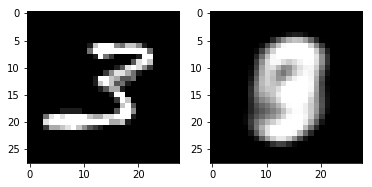

In [52]:
predict(model, dset_test)

In [41]:
correct = 0
for i, (x, y) in enumerate(iter(loader_test)):
    x = Variable(x)
    out, _ = model(x)
    prob = torch.sqrt((out ** 2).sum(-1))
    _, y_pred = torch.max(prob, 1)
    correct += y_pred.data.eq(y).sum()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [43]:
print('Accuracy: %s' % (correct / len(dset_test)))

Accuracy: 0.9924
